In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split

import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/Omdena/split_data_balanced"

Mobile_net.pth	test  train


In [4]:
data_dir = "/content/drive/MyDrive/Omdena/split_data_balanced"

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(len(classes))
num_cls=len(classes)

['test', 'train', 'Mobile_net.pth']
2


In [5]:
# spinach_files = os.listdir(data_dir + "/train/spinach")
# print('No. of training examples for spinach images:', len(spinach_files))
# print(spinach_files[:5])

In [6]:
from torchvision.datasets import ImageFolder

from torchvision import transforms
from torchvision.transforms import ToTensor

train_transformations = transforms.Compose([
    transforms.Resize((255,255)),
    transforms.ToTensor()
])

test_transformations = transforms.Compose([
    transforms.Resize((255,255)),
    transforms.ToTensor()
])

training_dataset = ImageFolder(data_dir+'/train', transform=train_transformations)
testing_dataset= ImageFolder(data_dir+'/test', transform=test_transformations)

In [7]:
print(training_dataset.classes)
print(len(training_dataset.classes))

['normal', 'pneumonia']
2


Label:  normal (0)


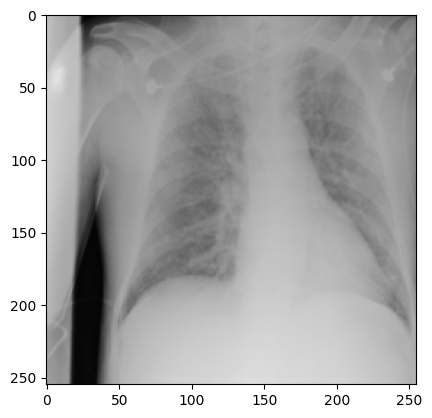

In [8]:

import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', training_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*training_dataset[700])

In [9]:

random_seed = 42
torch.manual_seed(random_seed);

val_size = 250
train_size = len(training_dataset) - val_size

train_ds, val_ds = random_split(training_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(15100, 250)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


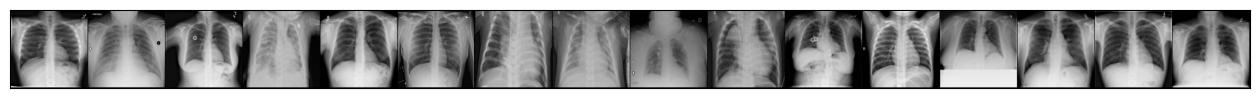

In [10]:

from torch.utils.data.dataloader import DataLoader

batch_size=16

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)


from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()

        train_losses = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [18]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [19]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return training_dataset.classes[preds[0].item()]

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)

        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)

        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Flatten(),
                                        nn.Linear(512*15*15, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)

        out = self.res1(out) + out

        out = self.conv3(out)
        out = self.conv4(out)

        out = self.res2(out) + out

        out = self.classifier(out)
        return out

In [21]:
import math

def conv_bch_norm(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_dim1_bch_norm(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def give_division_number(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        dimension_size_hidden = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup
        if expand_ratio == 1:
            self.conv = nn.Sequential(
                nn.Conv2d(dimension_size_hidden, dimension_size_hidden, 3, stride, 1, groups=dimension_size_hidden, bias=False),
                nn.BatchNorm2d(dimension_size_hidden),
                nn.ReLU6(inplace=True),
                nn.Conv2d(dimension_size_hidden, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(inp, dimension_size_hidden, 1, 1, 0, bias=False),
                nn.BatchNorm2d(dimension_size_hidden),
                nn.ReLU6(inplace=True),
                nn.Conv2d(dimension_size_hidden, dimension_size_hidden, 3, stride, 1, groups=dimension_size_hidden, bias=False),
                nn.BatchNorm2d(dimension_size_hidden),
                nn.ReLU6(inplace=True),
                nn.Conv2d(dimension_size_hidden, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, inv_object):
        if self.use_res_connect:
            return inv_object + self.conv(inv_object)
        else:
            return self.conv(inv_object)


class MobileNetV2(ImageClassificationBase):
    def __init__(self, num_of_class=num_cls, in_size_dim=224, mult_width_config=1.):
        super(MobileNetV2, self).__init__()
        blk = InvertedResidual
        in_ch = 32
        final_ch = 1280

        config_inversions_congestion = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 1, 2],
            [6, 96, 2, 1],
            [6, 160, 2, 2],
            [6, 320, 1, 1],
        ]
        assert in_size_dim % 32 == 0
        self.last_channel = give_division_number(final_ch * mult_width_config) if mult_width_config > 1.0 else final_ch
        self.features = [conv_bch_norm(3, in_ch, 2)]

        for t, c, n, s in config_inversions_congestion:
            out_ch = give_division_number(c * mult_width_config) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(blk(in_ch, out_ch, s, expand_ratio=t))
                else:
                    self.features.append(blk(in_ch, out_ch, 1, expand_ratio=t))
                in_ch = out_ch
        self.features.append(conv_dim1_bch_norm(in_ch, self.last_channel))
        self.features = nn.Sequential(*self.features)
        self.classifier = nn.Linear(self.last_channel, num_of_class)
        self._initialize_weights()

    def _initialize_weights(self):
        for each_module in self.modules():
            if isinstance(each_module, nn.Conv2d):
                p = each_module.kernel_size[0] * each_module.kernel_size[1] * each_module.out_channels
                each_module.weight.data.normal_(0, math.sqrt(2. / p))
                if each_module.bias is not None:
                    each_module.bias.data.zero_()
            elif isinstance(each_module, nn.BatchNorm2d):
                each_module.weight.data.fill_(1)
                each_module.bias.data.zero_()
            elif isinstance(each_module, nn.Linear):
                p = each_module.weight.size(1)
                each_module.weight.data.normal_(0, 0.01)
                each_module.bias.data.zero_()

    def forward(self, mn_object):
        mn_object = self.features(mn_object.to(device))
        mn_object = mn_object.mean(3).mean(2)
        mn_object = self.classifier(mn_object)
        return mn_object

In [22]:
# model_resnet = to_device(ResNet9(3, 36), device)
# model_resnet

model_mobilenet = to_device(MobileNetV2(mult_width_config=1, num_of_class=num_cls), device)
model_mobilenet

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [23]:
# history3 = [evaluate(model_resnet, val_dl)]
# history3
history=[evaluate(model_mobilenet, val_dl)]
history

[{'val_loss': 0.6931474208831787, 'val_acc': 0.46484375}]

In [24]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [25]:
# history3 = fit(num_epochs, lr, model_resnet, train_dl, val_dl, opt_func)
history_mob = fit(num_epochs, lr, model_mobilenet, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4448, val_loss: 0.5465, val_acc: 0.7758
Epoch [1], train_loss: 0.3704, val_loss: 0.3589, val_acc: 0.8597
Epoch [2], train_loss: 0.3381, val_loss: 0.3115, val_acc: 0.8675
Epoch [3], train_loss: 0.3200, val_loss: 0.3060, val_acc: 0.8879
Epoch [4], train_loss: 0.3038, val_loss: 0.3104, val_acc: 0.8684
Epoch [5], train_loss: 0.2919, val_loss: 0.2808, val_acc: 0.8936
Epoch [6], train_loss: 0.2815, val_loss: 0.3232, val_acc: 0.8528
Epoch [7], train_loss: 0.2720, val_loss: 0.2876, val_acc: 0.8810
Epoch [8], train_loss: 0.2599, val_loss: 0.2841, val_acc: 0.8675
Epoch [9], train_loss: 0.2446, val_loss: 0.2898, val_acc: 0.8645


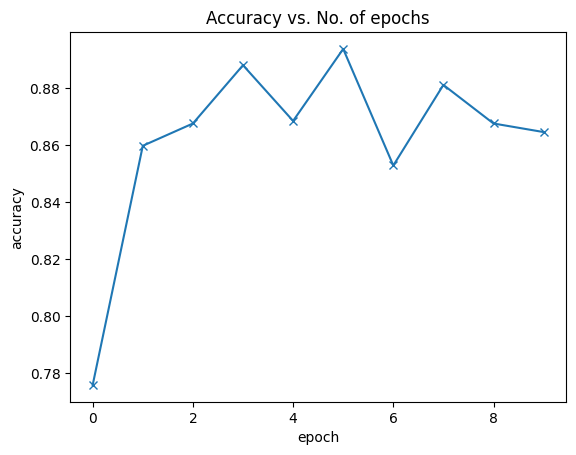

In [26]:
plot_accuracies(history_mob)

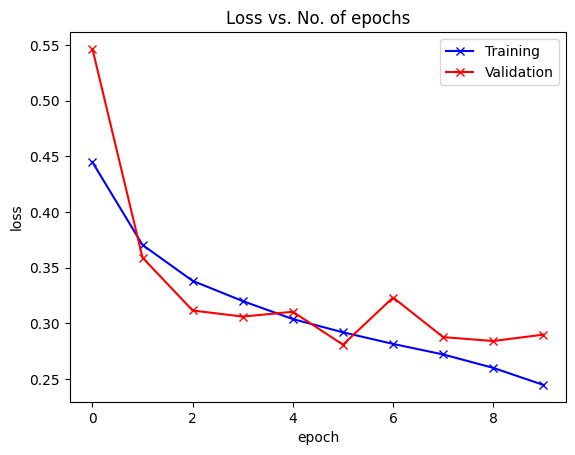

In [27]:
plot_losses(history_mob)


Label: normal , Predicted: normal


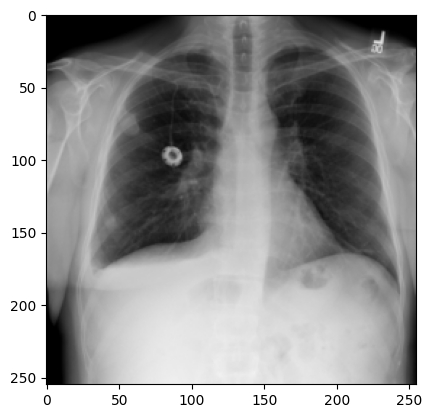

In [28]:
img, label = testing_dataset[76]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_mobilenet))


Label: normal , Predicted: normal


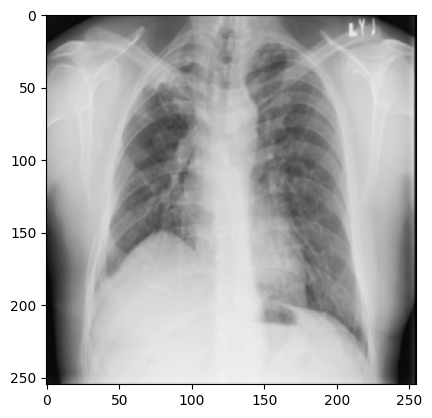

In [29]:
img, label = testing_dataset[160]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_mobilenet))

In [30]:
path = "/content/drive/MyDrive/Omdena/split_data_balanced/Mobile_net.pth"
torch.save(model_mobilenet.state_dict(), path)

In [31]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_mobilenet, test_loader)
result

{'val_loss': 0.2899916470050812, 'val_acc': 0.8838021159172058}